# Práctica 4: Umbralización

En esta práctica vamos a programar algunos de los algoritmos vistos en clase sobre umbralización. El objetivo es seguir afianzando los conocimientos de programación y tener una visión más clara sobre qué hace cada uno de los algoritmos vistos en clase

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Como hemos comentado en clase, segmentar una imagen mediante umbralización consiste en encontrar un umbral $q\in [0,255]$ que divida la imagen en dos clases, $C_0$ y $C_1$, de manera que

$$I(x,y)\in\begin{cases}
    C_0 & \text{ if }I(x,y)\le q \\
    C_1 & \text{ if }I(x,y)> q \\
\end{cases}$$

**Nota**: Dado que estamos asumiendo que $C_0$ contiene aquellas intensidades menores o iguales que $q$, solemos exigir realmente que  $q\in [0,254]$, para así no dejar ninguna de las dos clases vacías. 

Vamos a comenzar viendo una forma manual de elección de umbral. Abre la imagen 01.bmp y visualiza el histograma.

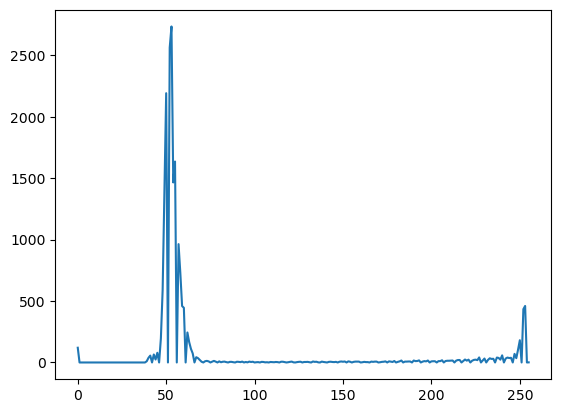

In [2]:
imagen = cv2.imread('images/01.bmp', 0)
hist = cv2.calcHist([imagen],[0],None,[256],[0,256])

plt.plot(hist)


Vamos a elegir tres umbrales diferentes para que observemos las diferencias que podemos encontrarnos.

In [3]:
q_1 = 55
q_2 = 150
q_3 = 250

A continuación, crea tres imágenes segmentadas utilizando cada uno de los umbrales. Recuerda que una imagen segmentada la vamos a visualizar (por ahora) con 2 colores: negro para los píxeles de $C_0$ y blanco para los de $C_1$ (esto es una elección arbitraria y podría ser al revés o con cualesquiera otros colores). Lo importante es que no utilicemos bucles para generar las imágenes.

In [4]:
segmentada_1 = np.where(imagen <= q_1, 0, 255)
segmentada_2 = np.where(imagen <= q_2, 0, 255)
segmentada_3 = np.where(imagen <= q_3, 0, 255)

Por último, visualiza las tres imágenes a la vez, junto a la imagne original.

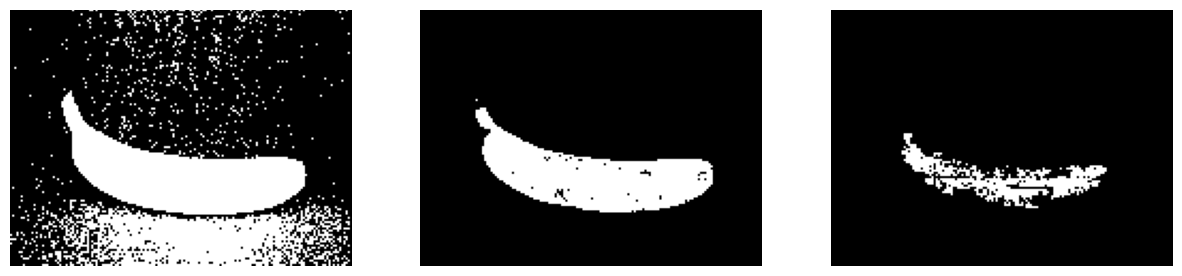

In [5]:
fig, axes = plt.subplots(1,3, figsize=(15,10))

axes[0].imshow(segmentada_1, cmap='gray', vmin=0, vmax=255)
axes[1].imshow(segmentada_2, cmap='gray', vmin=0, vmax=255)
axes[2].imshow(segmentada_3, cmap='gray', vmin=0, vmax=255)
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
plt.show()
# cv2.imshow('Original', imagen)
# cv2.imshow('Segmentada 1', segmentada_1)
# cv2.imshow('Segmentada 2', segmentada_2)
# cv2.imshow('Segmentada 3', segmentada_3)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Como puedes observar, el umbral $q_2$ ofrece una imagne segmentada de mayor calidad que las demás. Evidentemente, no podemos hacer esta búsqueda manual y, por tanto, necesitamos algoritmos automáticos que nos permitan obtener los mejores umbrales.

### Ejercicio 1: mínimo entre máximos

El primer programa que vamos a implementar es la umbralización de mínimo entre máximos. Para ello, crea una función que reciba como parámetro de entrada una imagen. El programa obtendrá el histograma de la imagen. A partir del histograma es muy sencillo obtener la posición que ocupa el máximo global del histograma (recuerda la función argmax). El siguiente paso es encontrar el segundo pico del histograma. Recuerda que no es tan sencillo como buscar el segundo máximo del histograma, sino que tenemos que recorrer cada una de las intensidades:
- calcular el pico del histograma $q_1=\arg \max_i h(i)$
- para cada intensidad i:
    - Calcular $h(i)\times |i-q_1|$
- tomar como $q_2$  la posición que maximice la expresión anterior

Una vez localizados $q_1,q_2$, busca el mínimo del histograma entre ambos picos. Umbraliza la imagen utilizando dicho umbral. Recuerda que puedes hacer algo como
 $$umbralizada = 255*(imagen<=q).astype(np.uint8)$$
 

In [6]:
def min_entre_max(imagen):
    
    hist = cv2.calcHist([imagen],[0],None,[256],[0,256])
    q1 = np.argmax(hist)
    q2 = 0
    valor_max = 0

    for i in range(0,256):
        q_max2 = hist[i] * np.abs(i-q1)
        if q_max2 > valor_max:
            valor_max = q_max2
            q2 = i
        
    pico1 = min(q1,q2)
    pico2 = max(q1,q2)
    q = np.argmin(hist[pico1:pico2+1]) + pico1
    umbralizada = 255*(imagen <=q).astype(np.uint8)

    return umbralizada

In [9]:
def mostrar_imagen(imagen):
    fig,axes = plt.subplots(figsize=(10,10))
    axes.imshow(imagen, cmap='gray',vmin=0,vmax=255)
    axes.axis('off')
    plt.show()

Una vez programada llama a la función con la imagen 01.bmp. Si devuelves el primer mínimo que encuentres, deberías tener como umbral $q=56$ ¿Obtienes un buen resultado? ¿Por qué? ¿Qué pegas encuentras?

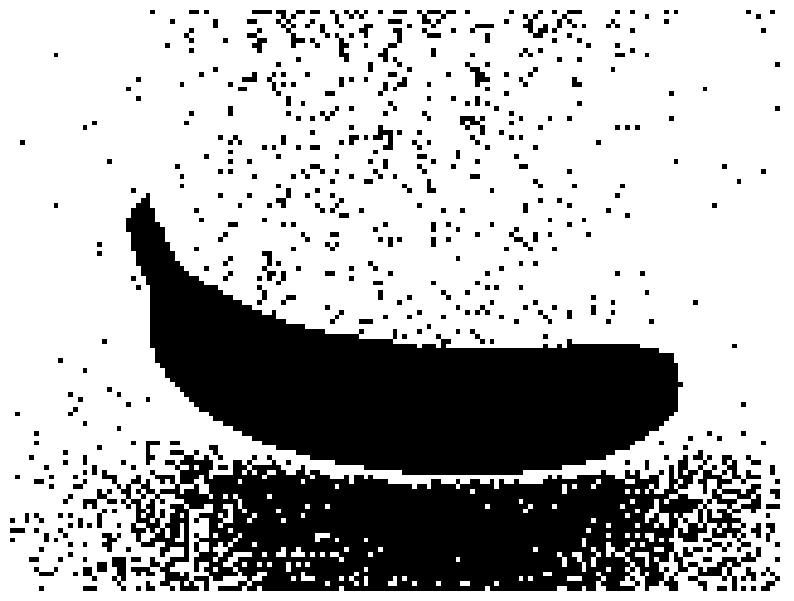

In [10]:
imagen = cv2.imread('images/01.bmp', 0)
umbralizada = min_entre_max(imagen)

mostrar_imagen(umbralizada)
# cv2.imshow('Umbralizacion minimo entre maximos', umbralizada)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Ejercicio 2: isodata

Como puedes observar, el umbral obtenido en el ejercicio anterior no es de muy buena calidad. La utilización del mínimo entre máximos solo funciona ante histogramas casi "perfectos". Por eso, es necesario ir hacia métodos iterativos que traten de obtener información estadística del histograma. El más sencillo es isodata. 

Realizar una función en Python que implemente el algoritmo de las medias móviles:
- Tomar como umbral inicial $q'$ la media de las intensidades de la imagen $\mu_I$
- Calcular $C_0,C_1,\mu_0,\mu_1$
- Tomar como umbral $q$ la media entre $\mu_0$ y $mu_1$
- Mientras $q$ y $q'$ sean distintos:
 - Tomar como $q'$ el valor de $q$
 - Recalcular $C_0,C_1,\mu_0,\mu_1$
 - Recalcular $q$ como la media de las medias

**Nota:**el valor de las medias los podéis obtener directamente utilizando np.mean


In [56]:
def isodata(imagen):
    q_prima = np.mean(imagen)
    mean_0 = np.mean(imagen[imagen<q_prima])
    mean_1 = np.mean(imagen[imagen>=q_prima])
    q = np.mean([mean_0, mean_1])
    while(q_prima != q):
        q_prima = q
        mean_0 = np.mean(imagen[imagen<q_prima])
        mean_1 = np.mean(imagen[imagen>=q_prima])
        q = np.mean([mean_0, mean_1])

    umbralizada = 255*(imagen <=q).astype(np.uint8)
    
    print(q)
    return umbralizada

In [91]:
def isodata2(imagen):
    hist_norm = (cv2.calcHist([imagen],[0],None,[256],[0,256]) / imagen.size).squeeze()
    intensidades = np.arange(256)
    epsilon = 1e-10
    media = int(np.sum(hist_norm * intensidades))

    p0,p1 = np.sum(hist_norm[:media])+epsilon, np.sum(hist_norm[media:])+epsilon
    media0 = np.sum(hist_norm[:media] * intensidades[:media]) /p0
    media1 = np.sum(hist_norm[media:] * intensidades[media:]) /p1
    media_fin = (media0 + media1) / 2
    media_final = int(round(media_fin))

    while media != media_final:
        media = media_final
        p0,p1 = np.sum(hist_norm[:media])+epsilon, np.sum(hist_norm[media:])+epsilon
        media0 = np.sum(hist_norm[:media] * intensidades[:media]) /p0
        media1 = np.sum(hist_norm[media:] * intensidades[media:]) /p1
        media_fin = (media0 + media1) / 2
        media_final = int(round(media_fin))
    
    print(media)
    umbralizada = 255*(imagen <=media).astype(np.uint8)

    return umbralizada

143


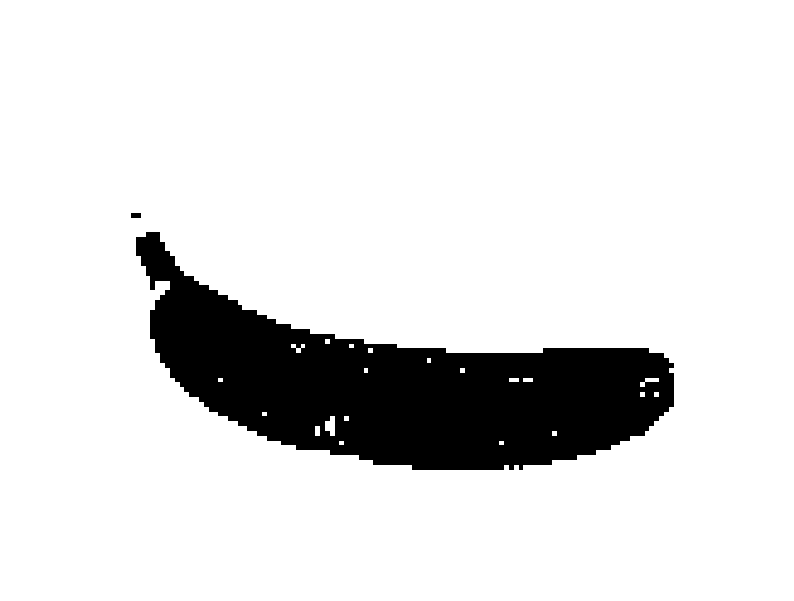

In [92]:
imagen = cv2.imread('images/01.bmp', 0)
umbralizada = isodata2(imagen)
mostrar_imagen(umbralizada)
# cv2.imshow('Umbralizacion minimo entre maximos', umbralizada)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Ejercicio 3: Otsu

Realizar una función en python que implemente el algoritmo de Otsu. Para ello, vamos a crear un array vacío de 256 posiciones. En la posición q-ésima del vector almacenaremos la varianza entre clases $\sigma_b(q)$ tomando como umbral el valor de intensidad q. Por último obtenendremos como umbral aquel asociado a la máxima varianza entre clases. Recuerda que para calcular la varianza entre clases dado q debemos calcular:
- $p_1$: probabilidad de la clase 1
- $p_2$: probabilidad de la clase 2
- $\mu_1$: media de la clase 1
- $\mu_2$: media de la clase 2
- varianza entre clases: $\sigma_b(q)=p_1p_2(\mu_1- \mu_2)^2$

Estos cálculos se pueden hacer de dos maneras distintas. Una opción sería utilizando funciones de numpy como np.mean, etc. Otra opción sería utilizar el histograma de la imagen y calcular $p_1,p_2,\mu_1,\mu_2$ utilizando únicamente el histograma. Estos cálculos se pueden hacer de dos maneras distintas. Una opción sería utilizando funciones de numpy como np.mean, etc. Otra opción sería utilizar el histograma de la imagen y calcular $p_1,p_2,\mu_1,\mu_2$ utilizando únicamente el histograma. Puedes elegir aquella que te resulte más sencilla.

In [35]:
def otsu(imagen):
    varianzas = np.zeros(256)
    for i in range(1,255):
        mask1, mask2 = (imagen <i), (imagen >= i)
        p1 = imagen[mask1].size / imagen.size
        p2 = imagen[mask2].size / imagen.size
        u1 = np.mean(imagen[mask1])
        u2 = np.mean(imagen[mask2])
        varianzas[i] = p1*p2*(np.square(u1-u2))

    q = np.argmax(varianzas)
    
    umbralizada = 255 * (imagen<= q).astype(np.uint8)
    return umbralizada

Una vez programada, prueba la umbralización con la imagen 01.bmp. Comprueba que obtienes el umbral 143.

Compara las imagenes obtenidas con el Ejercicio 1 y el Ejercicio 2. ¿Por qué crees que el resultado del Ejercicio 1 no tiene tanta calidad?

Prueba ahora a suavizar la imagen con un filtro Gaussiano (o un filtro de la media 3x3 o 5x5) y luego umbraliza con la función Otsu. ¿Obtienes alguna mejora?


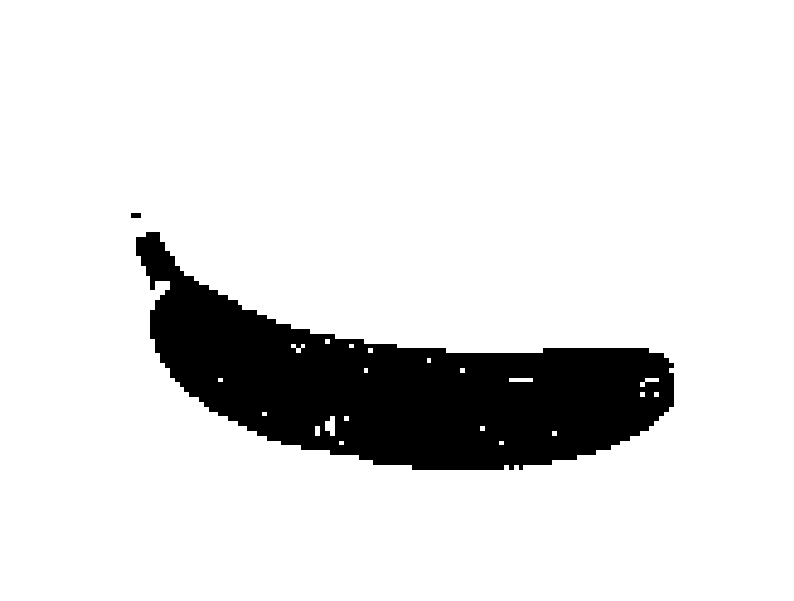

In [36]:
imagen = cv2.imread('images/01.bmp', 0)
umbralizada = otsu(imagen)
mostrar_imagen(umbralizada)
# cv2.imshow('Umbralizacion Otsu', umbralizada)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Ejercicio 4: Umbralizació de mínimo error

Este algoritmo es algo parecido al anterior. Vamos a ir probando cada uno de las intensidades posibles como umbral y, para cada una, calcularemos una distribución de probabilidad gaussiana según la media y la desviación de los píxeles de la clase 0 y clase 1 en función del umbral. Para ello, recorre el conjunto de intensidades y calcula:
- $p_0$: probabilidad de la clase0
- $p_1$: probabilidad de la clase1
- $\mu_0$: media de la clase 0
- $\mu_1$: media de la clase 1
- $\sigma_0^2$: varianza de la clase 0
- $\sigma_1^2$: varianza de la clase 1


Una vez tenemos los parámetros de cada una de las clases, vamos a calcular el error que cometemos al asignar cada una de las intensidades a la clase 0 y a la clase 1 en función del umbral. Esto se calcula como

$$e(q)=\sum_{i=0}^{q}h_p(i)e_0(i)+\sum_{i=q+1}^{255}h_p(i)e_1(i)$$

donde

$$e_j(i)=\frac{(i-\mu_j)^2}{\sigma_j^2}+2(\log(\sigma_j)-\log(p_0))$$

Nota: en el cálculo de las varianzas, podemos sumarle a la variable un pequeño valor (1e-10) para evitar el logaritmo de 0.

Una vez calculado el error por cada posible umbral, tomaremos aquel que minimice el error cometido.

In [47]:
def minimo_error(imagen):
    hist_norm = cv2.calcHist([imagen],[0],None, [256],[0,256]) / imagen.size
    epsilon = 1e-10
    error = np.zeros(256)
    intensidades = np.arange(256)

    for q in range(1,255):
        mask1, mask2 = (imagen < q), (imagen >= q)
        p0,p1 = imagen[mask1].size / imagen.size, imagen[mask2].size / imagen.size
        u0,u1 = np.mean(imagen[mask1]), np.mean(imagen[mask2])
        std0,std1 = np.std(imagen[mask1]) + epsilon, np.std(imagen[mask2]) + epsilon
        var0, var1 = std0**2, std1**2
        e0 = (np.square(intensidades - u0) / var1) + (2 * (np.log(std0) - np.log(p0)))
        e1 = (np.square(intensidades - u1) / var0) + (2 * (np.log(std1) - np.log(p1)))

        error[q] = np.sum(hist_norm[0:q+1]* e0[0:q+1]) + np.sum(hist_norm[q:256] * e1[q:256])

    error[0], error[255] = np.inf, np.inf
    q_optimo = np.argmin(error)
        
    umbralizada = 255 * (imagen<= q_optimo).astype(np.uint8)
    return umbralizada

Una vez programado, comprueba su funcionamiento con las imágenes de antes y revisa si obtienes umbral 78. Al igual que aparece en las explicaciones de clase, podríamos pintar encima del histograma las dos distribuciones gaussianas que tratan de ajustarse al histograma. Para ello, una vez conocido el umbral q, las distribcuines gaussianas de la clase 0 y de la clase 1 vendrían dadas, para cada posible intensidad x, por

$$\frac{1}{\sqrt{2\pi\sigma_0^2}}*\exp\left(-\frac{(x-\mu_0)^2}{2\sigma_0^2}\right)$$
$$\frac{1}{\sqrt{2\pi\sigma_1^2}}*\exp\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right)$$

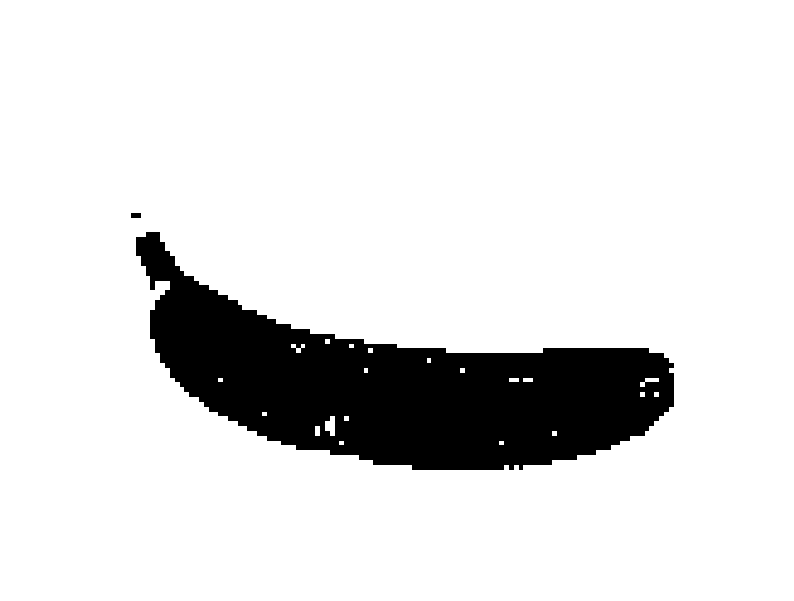

In [48]:
imagen = cv2.imread('images/01.bmp', 0)
umbralizada = minimo_error(imagen)

mostrar_imagen(umbralizada)
# cv2.imshow('Umbralizacion Otsu', umbralizada)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Ejercicio 5: Umbralización variable

Uno de los problemas del algoritmo de Otsu aparece cuando la iluminación de la imagen no es constante. Lee la imagen texto.tif. Visualiza y aplica el algoritmo del ejercicio 2 (otsu). Comprueba que la segmentación no es la adecuada. Vamos a solventar este problema mediante una umbralización variable, es decir, una combinación de técnicas globales y locales. De hecho, vamos a ver que se parece mucho a un filtro no lineal sobre la imagen. El algoritmo es el siguiente:
- para cada píxel de la imagen
    - tomar una ventana 3x3 de píxeles centrada en el
    - calcular la media aritmética $\mu_{x,y}$ y la desviación típica $\sigma_{x,y}$
    - Realizar la siguiente segmentación 
    $$g(x,y)=\begin{cases} 
        1 & \text{ si } imagen(x,y)<\sigma_{x,y}+0.5\mu_{x,y} \\
        0 & \text{ en otro caso}
    \end{cases}$$

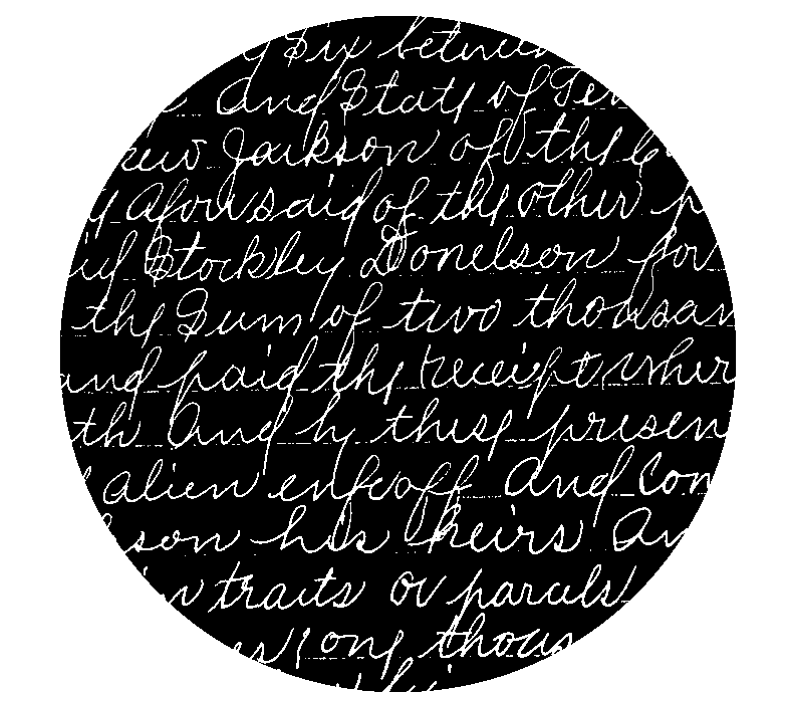

In [49]:
imagen = cv2.imread('images/texto.tif', 0)
# cv2.imshow('Imagen texto', imagen)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

texto_umbralizada = otsu(imagen)
mostrar_imagen(texto_umbralizada)

In [54]:
def variable(imagen):
    h,w = imagen.shape
    img_amp = cv2.copyMakeBorder(imagen, 1,1,1,1, cv2.BORDER_REPLICATE).astype(np.float32)
    g = np.zeros_like(imagen)
    for i in range(1,h+1):
        for j in range(1,w+1):
            ventana = img_amp[i-1:i+2, j-1:j+2]
            media = np.mean(ventana)
            sigma = np.std(ventana)
            if img_amp[i,j]  < (0.5*media + sigma):
                g[i-1,j-1] = 1
            else:
                g[i-1,j-1] = 0
    
    return g

Comprueba ahora que la umbralización variable funciona bien en este ejemplo concreto. Evidentemente, la fórmula elegida es ad-hoc para la imagen concreta, pero en función de la iluminación podríamos elegir otras condiciones del estilo 
$$imagen(x,y)<a \sigma_{x,y} + b \mu_{x,y}$$
siendo $a$ y $b$ dos números cualesquiera.

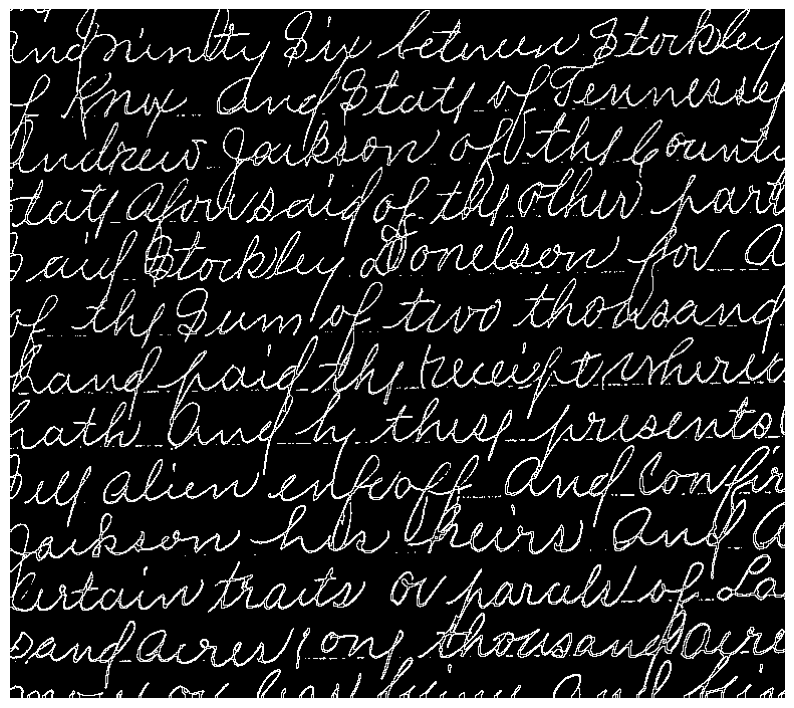

In [55]:
imagen = cv2.imread('images/texto.tif', 0)
texto_umbralizada_2 = variable(imagen)*255
mostrar_imagen(texto_umbralizada_2)
# cv2.imshow('Umbralizacion Variable', texto_umbralizada_2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()